In [1]:
using DataFrames
using Gadfly

In [2]:
# Load benchmark data from file
benchmarks = readtable("benchmarks.csv", header=false, names=[:language, :benchmark, :time])

# Capitalize and decorate language names from datafile
dict = Dict("c"=>"C", "julia"=>"Julia", "lua"=>"LuaJIT", "fortran"=>"Fortran", "java"=>"Java",
    "javascript"=>"JavaScript", "matlab"=>"Matlab", "mathematica"=>"Mathe-\nmatica", 
    "python"=>"Python", "octave"=>"Octave", "r"=>"R", "go"=>"Go")

benchmarks[:language] = [dict[lang] for lang in benchmarks[:language]]

# Normalize benchmark times by C times
ctime = benchmarks[benchmarks[:language].== "C", :]
benchmarks = join(benchmarks, ctime, on=:benchmark)
delete!(benchmarks, :language_1)
rename!(benchmarks, :time_1, :ctime)
benchmarks[:normtime] = benchmarks[:time] ./ benchmarks[:ctime];

# Compute the geometric mean for each language
langs = [];
means = [];
priorities = [];
for lang in values(dict)
    data = benchmarks[benchmarks[:language].== lang, :]
    gmean = geomean(data[:normtime])
    push!(langs, lang)
    push!(means, gmean)
    if (lang == "C")
        push!(priorities, 1)
    elseif (lang == "Julia")
        push!(priorities, 2)        
    else
        push!(priorities, 3)
    end
end

# Add the geometric means back into the benchmarks dataframe
langmean = DataFrame(language=langs, geomean = means, priority = priorities)
benchmarks = join(benchmarks, langmean, on=:language)

# Put C first, Julia second, and sort the rest by geometric mean
sort!(benchmarks, cols=[:priority, :geomean]);

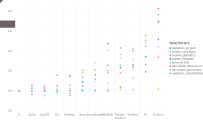

In [3]:
p = plot(benchmarks,
    x = :language,
    y = :normtime,
    color = :benchmark,
    Scale.y_log10,
    Guide.ylabel(nothing),
    Guide.xlabel(nothing),
    Coord.Cartesian(xmin=1,xmax=12.3,ymin=-1,ymax=4.2),
    Theme(
        guide_title_position = :left,
        colorkey_swatch_shape = :circle,
        minor_label_font = "Georgia",
        major_label_font = "Georgia",
    ),
)
draw(SVG(8inch,8inch/golden), p)

In [5]:
draw(SVG("../_includes/benchmarks.svg", 8inch, 8inch/golden), p)

false

In [6]:
perm = sortperm(means)
println("cputime\tlang") 
for p in perm
    if langs[p] == "Mathe-\nmatica"
        langs[p] = "Mathematica"
    end
    @printf "%0.3f\t%s\n" means[p] langs[p]
end

cputime	lang
1.000	C
1.101	Julia
1.107	LuaJIT
1.467	Go
1.622	Fortran
2.963	Java
4.157	JavaScript
10.076	Matlab
14.218	Mathematica
18.534	Python
72.239	R
471.252	Octave
